# Introduction

In this notebook we will visualize the network of an Instagram user.
* We will look at all the people tagged in user's pics and order them by the number of tags
* Then we access their profile pictures and make them circular with a nice frame (using the `PIL` package)
* The network will be visualized in such a way that the user will be one large central node, and all the people tagged in its photos will be nodes connected to it, evenly distributed around it, with edge lengths inversely proportional to the the number of tags
* We will use this information to find the optimal positions of all the nodes in a given figure, draw the edges and export the figure with a transparent background

In [1]:
%pylab inline
import networkx as nx
import numpy as np
from os import listdir
from PIL import Image, ImageOps, ImageDraw
import urllib2 as urllib
import io

Populating the interactive namespace from numpy and matplotlib


# Edit the profile pics

Load a sample rectangular profile picture from my public Dropbox:

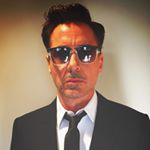

In [2]:
test_url = "https://dl.dropboxusercontent.com/u/51646672/profile_pics_test/prof4.jpg"
image_file = urllib.urlopen(test_url)
image_data = io.BytesIO(image_file.read())
im = Image.open(image_data)
im

First, let's make this image circular. To do that, start with creating a new rectangular image, several times the size of the original image (we'll see later why) and make it solid black:

In [3]:
large_size = (im.size[0] * 5, im.size[1] * 5)
mask = Image.new('L', large_size, 0)

This will be used as a mask, i.e. we'll draw a white solid ellipse in it, and resize it to the image's size (we start with the larger ellipse, so when it's resized, it looks smoother) (Also note the use of anti-alias to make the resizing interpolation smooth):

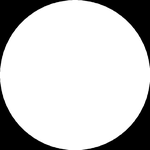

In [4]:
draw_mask = ImageDraw.Draw(mask) 
draw_mask.ellipse((0, 0) + large_size, fill = 255)
mask = mask.resize(im.size, Image.ANTIALIAS)
mask

The final step is to use this image as an alpha layer of the original image: the more black an area of the alpha layer is, the more transparent that part of the image is:

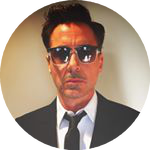

In [5]:
im.putalpha(mask)
im

Now let's add a frame. The first step is to paste this picture on top of a solid background, slightly larger than the image;

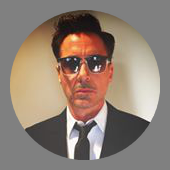

In [6]:
frame_width = 5
frame_offset = 5
frame_color = 'gray'
new_size = (im.size[0] + 2*frame_width + 2*frame_offset, im.size[1] + 2*frame_width + 2*frame_offset)
im_framed = Image.new('RGB', new_size, 'gray')
im_framed.paste(im, (frame_width + frame_offset, frame_width + frame_offset), im)
im_framed

Now we do the same as before: define a circular mask and use it as an alpha layer in this image:

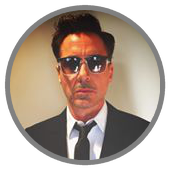

In [7]:
new_large_size = (new_size[0] * 5, new_size[1] * 5)
new_mask = Image.new('L', new_large_size, 0)
new_draw_mask = ImageDraw.Draw(new_mask) 
ellipse_coords = ((frame_offset + im.size[0] + 2*frame_width)*5, (frame_offset + im.size[0] + 2*frame_width)*5)
new_draw_mask.ellipse((frame_offset * 5, frame_offset * 5) + ellipse_coords, fill = 255)
new_mask = new_mask.resize(new_size, Image.ANTIALIAS)
im_framed.putalpha(new_mask)
im_framed

Now this can be resized (note the use of anti-alias) and saved (but to a PNG file, to preserve the transparency):

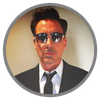

In [8]:
resized_im = im_framed.resize((100,100), Image.ANTIALIAS)
resized_im
# resized_im.save("test.PNG", 'PNG', quality = 90)

Put it all in a function:

In [10]:
def circularize(url, width = 100):
    # Load image
    image_file = urllib.urlopen(url)
    image_data = io.BytesIO(image_file.read())
    im = Image.open(image_data)
    # Make it circular (no frame)
    large_size = (im.size[0] * 5, im.size[1] * 5)
    mask = Image.new('L', large_size, 0)
    draw_mask = ImageDraw.Draw(mask) 
    draw_mask.ellipse((0, 0) + large_size, fill = 255)
    mask = mask.resize(im.size, Image.ANTIALIAS)
    im.putalpha(mask)
    # Add a square frame with an offset
    frame_width = 5
    frame_offset = 5
    frame_color = 'gray'
    new_size = (im.size[0] + 2*frame_width + 2*frame_offset, im.size[1] + 2*frame_width + 2*frame_offset)
    im_framed = Image.new('RGB', new_size, 'gray')
    im_framed.paste(im, (frame_width + frame_offset, frame_width + frame_offset), im)
    # Make the frame circular
    new_large_size = (new_size[0] * 5, new_size[1] * 5)
    new_mask = Image.new('L', new_large_size, 0)
    new_draw_mask = ImageDraw.Draw(new_mask) 
    ellipse_coords = ((frame_offset + im.size[0] + 2*frame_width)*5, (frame_offset + im.size[0] + 2*frame_width)*5)
    new_draw_mask.ellipse((frame_offset * 5, frame_offset * 5) + ellipse_coords, fill = 255)
    new_mask = new_mask.resize(new_size, Image.ANTIALIAS)
    im_framed.putalpha(new_mask)
    # Final resize
    resized_im = im_framed.resize((width, width), Image.ANTIALIAS)
    return resized_im

Test it

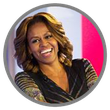

In [11]:
circularize("https://dl.dropboxusercontent.com/u/51646672/profile_pics_test/prof2.jpg", width = 110)

# Use the images as nodes

First we need to load and circularize all the relevant profile pics, and for that, we need to decide on their size (so there's no more resizing):

In [12]:
prim_width = 110
sec_width = 70

All the URLs will be in list of length 1+N, where N is the number of people tagged, and the +1 (the first element) is the central profile:

In [13]:
prof_urls = ["https://dl.dropboxusercontent.com/u/51646672/profile_pics_test/prof" 
             + str(i) + ".jpg" for i in range(1,9)]
nNodes = len(prof_urls)

Let's load them up and circularize them:

In [14]:
node_pics = []
cnt = 1
for url in prof_urls:
    if cnt == 1: my_width = prim_width
    else: my_width = sec_width
    node_pics = node_pics + [circularize(url, width = my_width)]
    cnt = cnt + 1

Check it worked:

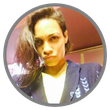

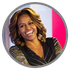

In [15]:
display(node_pics[0], node_pics[1])

Now we get the list of tags, which is also a list of length 1+N, that starts with a 0 (so that it matches up with the prof_urls list) and then the n-th element is the number of tag of the n-th user (from the prof_urls list) and the central user:

In [16]:
tag_list = [0] + [random.randint(1,5) for r in range(nNodes-1)]

Sort them, keeping the central node in place:

In [17]:
zip_tag_pics = [(tag_list[0],node_pics[0])]+ sorted(zip(tag_list[1:],node_pics[1:]), reverse=True)
tag_list=[tag for tag, pics in zip_tag_pics]
node_pics=[pics for tag, pics in zip_tag_pics]

We'll use some specific examples (see later for what Case 1 and Case 2 are):

In [48]:
# tag_list = [0, 3, 3, 3, 2, 2, 2, 1] # Case 1
tag_list = [0, 4, 3, 3, 2, 1, 1, 1] # Case 2

Use them to construct a weight matrix (for usage in networkX);

In [49]:
weight_matrix = array([0] * nNodes * nNodes).reshape((nNodes, nNodes))
weight_matrix[0] = tag_list
weight_matrix

array([[0, 4, 3, 3, 2, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

Generate a networkX graph from this, and assign a corresponding pic to each node:

In [50]:
G = nx.from_numpy_matrix(np.matrix(weight_matrix, dtype = [('weight', int)]))
cnt = 0
for n in G:
    G.node[n]['image'] = node_pics[cnt]
    cnt = cnt + 1

Now we need to figure out how to display the nodes. First, we need to fix the image size in pixels, and then distribute the nodes in an optimal way. To do that, we first fix the width of the figure (in inches) and fix the plot size (in axis units) to be between 0 and 1:

In [51]:
fig_width = 10
edge_width = 4

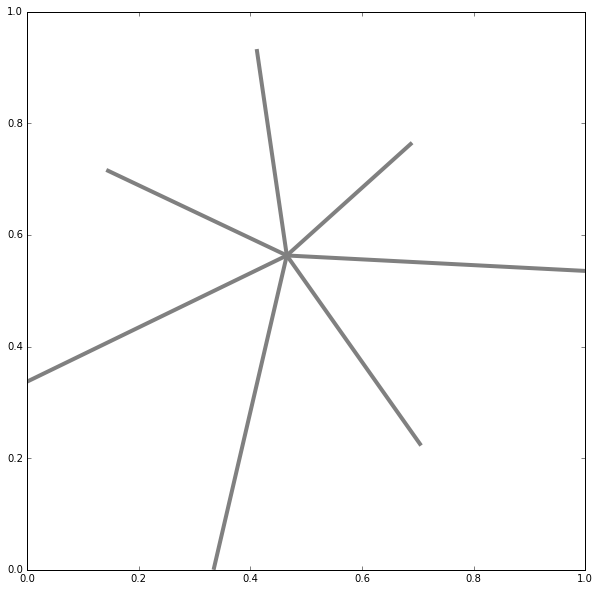

In [52]:
plt.rc('figure', figsize=(fig_width, fig_width))
fig = plt.figure(1)
ax = plt.subplot(111)
plt.xlim(0,1)
plt.ylim(0,1)
nx.draw_networkx_edges(G, pos = nx.spring_layout(G), width = edge_width, edge_color = 'gray');

We'll fix the dpi to be 72, which would mean that the pic should be 720 x 720 px. However, that produces awful lot of white space around the fig, which can be tackled (later) by specifying some options for `savefig`. Specifically, if one exports this with `fig.savefig('demo.png', transparent = True, dpi = 72, bbox_inches = 'tight', pad_inches = 0)`, the image size is 586 x 577 px. 

There are transformations (see e.g. [this tutorial](http://matplotlib.org/users/transforms_tutorial.html)) between the coordinate system of the axes and the display coordinate system;

In [53]:
ax_trans = ax.transData.transform
ax_trans_inv = ax.transData.inverted().transform

In [54]:
[ax_trans((0,0)), ax_trans((1,1)), ax_trans_inv((720, 720))]

[array([ 100.,  100.]), array([ 720.,  720.]), array([ 1.,  1.])]

Therefore, the size of the nodes in the axes coordinate system will be (note the transformation factor is there as the display has 80 ppi and we'll have 72 ppi)

In [55]:
ppi_conv = 80. / 72.

In [56]:
prim_width_ax = (ax_trans_inv((200 + ppi_conv * prim_width, 200 + ppi_conv * prim_width)) 
                 - ax_trans_inv((200, 200)))[0]
sec_width_ax = (ax_trans_inv((200 + ppi_conv * sec_width, 200 + ppi_conv * sec_width)) 
                - ax_trans_inv((200, 200)))[0]
sec_width_ax

0.12544802867383517

The idea is to put the central node at (xC, yC) position, put the the first node in the list (i.e the one with the highest number of tags) right next to it, at some distance r_min, and then the distance of the other nodes is scaled in a linear fashion, with the last node having r_max. 

If we try to put (xC, yC) in the center, for various situations, a lot of the image will be empty, so it's better to try to push it more up and right, and then we can increase r_max. So, this is what we'll do:
* Choose r_min in pixels based on some aesthetic guidelines, and calculate its size in the axis units
* Calculate the min and max number of tags, min_tags and max_tags, and calculate the height and width of the image (in axis units) if the edge with min_tags would have the distance r_min, and the one with max_tags, (max_tags / min_tags) x r_min.
* Case 1: If the size of the graph is smaller than 1, calculate by how much you can increase r_min, so that the graph fills up the available space -> this is your final graph.
* Case 2: If the size of the graph is larger than one, introduce a variable r_max (with slope and intercept) and calculate d_max that would give width = 1 and the one that would give height = 1 and choose the smaller -> this is your final graph.
* Now the size of the graph is fixed, and we can find (x_C,y_C) such that the image is centered

Fix the minimum r:

In [57]:
r_min_px = (prim_width / 2) + (sec_width / 2) + sec_width / 2
r_min = (ax_trans_inv((200 + ppi_conv * r_min_px, 200 + ppi_conv * r_min_px)) - ax_trans_inv((200, 200)))[0]
r_min

0.22401433691756276

Min and max number of tags:

In [58]:
min_tags = min(weight_matrix[0,1:])
max_tags = max(weight_matrix[0,1:])

Calculate the radial distances in the first case:

In [59]:
r_trial = (r_min * max_tags) / weight_matrix[0,1:]

Generate the node positions

In [60]:
x_pos = []
y_pos = []
for n in range(nNodes - 1):
    x_pos = x_pos + [r_trial[n] * cos(n * 2*pi / (nNodes - 1))]
    y_pos = y_pos + [r_trial[n] * sin(n * 2*pi / (nNodes - 1))]

Calculate the graph size:

In [61]:
graph_width = max(x_pos) - min(x_pos) + sec_width_ax
graph_height = max(y_pos) - min(y_pos) + sec_width_ax
[graph_width, graph_height]

[1.4914504209329325, 1.2902364542196221]

Determine which case we have:

In [62]:
if (graph_width <= 1) & (graph_height <= 1): case = 1
else: case = 2
case

2

# Case 1

Now we need to find the new r_min so that the graph fills the entire space. One could do this analytically, but it's simple to do it numerically, i.e. we'll keep increasing r_min in small increments until the graph becomes too big:

In [40]:
graph_too_big = False
new_r_min = r_min
while not graph_too_big:
    new_r_min = new_r_min + 0.01
    new_r_trial = (new_r_min * max_tags) / weight_matrix[0,1:]
    x_pos = []
    y_pos = []
    for n in range(nNodes - 1):
        x_pos = x_pos + [new_r_trial[n] * cos(n * 2*pi / (nNodes - 1))]
        y_pos = y_pos + [new_r_trial[n] * sin(n * 2*pi / (nNodes - 1))]
    graph_width = max(x_pos) - min(x_pos) + sec_width_ax
    graph_height = max(y_pos) - min(y_pos) + sec_width_ax
    if (graph_width > 1) | (graph_height > 1): graph_too_big = True
new_r_min = new_r_min - 0.01
new_r_min

0.25401433691756276

Go back one step, where the graph fits in the fig, and recalculate the positions;

In [41]:
new_r_trial = (new_r_min * max_tags) / weight_matrix[0,1:]
x_pos = []
y_pos = []
for n in range(nNodes - 1):
    x_pos = x_pos + [new_r_trial[n] * cos(n * 2*pi / (nNodes - 1))]
    y_pos = y_pos + [new_r_trial[n] * sin(n * 2*pi / (nNodes - 1))]
graph_width = max(x_pos) - min(x_pos) + sec_width_ax
graph_height = max(y_pos) - min(y_pos) + sec_width_ax

Now that we have the graph size, calculate the position of the central node:

In [42]:
xC = abs(min(x_pos)) + sec_width_ax / 2 + (1 - graph_width) / 2
yC = abs(min(y_pos)) + sec_width_ax / 2 + (1 - graph_height) / 2

Generate the dictionary of node positions (what networkX needs) by shifting the previously calculated node positions by (xC, yC):

In [43]:
node_pos = {0: array([xC, yC])}
for n in range(nNodes - 1):
    node_pos[n + 1] = array([xC + x_pos[n], yC + y_pos[n]])

See how it looks like:

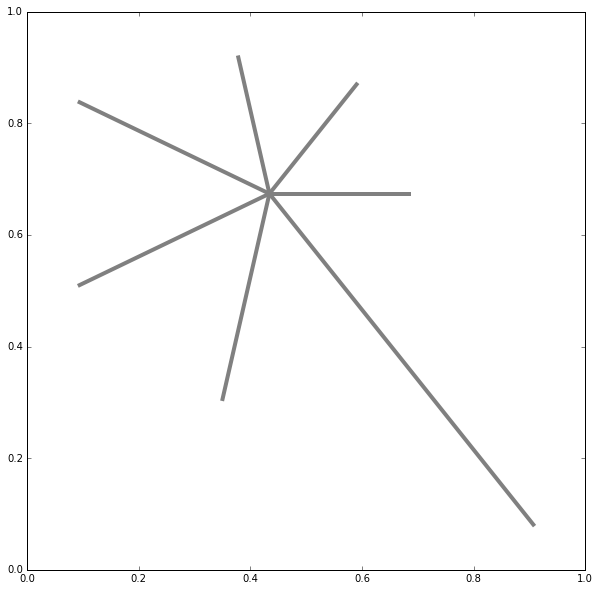

In [44]:
plt.rc('figure', figsize=(fig_width, fig_width))
fig = plt.figure(1)
ax = plt.subplot(111)
plt.xlim(0,1)
plt.ylim(0,1)
nx.draw_networkx_edges(G, pos = node_pos, width = edge_width, edge_color = 'gray');

Now we need to put the node images in this figure, which we'll do with `plt.axes`, and an `imshow` in it. However, `plt.axes` accepts coordinates in the figure coordinate system, where (0,0) is the lower left corner, rather than (0,0) of the axes. To convert we do something similar as before:

In [45]:
fig_trans = fig.transFigure.transform
fig_trans_inv = fig.transFigure.inverted().transform
[fig_trans((0,0)), fig_trans((1,1)), fig_trans_inv((720, 720))]

[array([ 0.,  0.]), array([ 800.,  800.]), array([ 0.9,  0.9])]

As we can see, the figure has a size of 800 in the display coordinate system, due to the 80 ppi resolution. We now find the node sizes in the figure coordinate system:

In [46]:
prim_width_fig = (fig_trans_inv((200 + ppi_conv * prim_width, 200 + ppi_conv * prim_width)) 
                 - fig_trans_inv((200, 200)))[0]
sec_width_fig = (fig_trans_inv((200 + ppi_conv * sec_width, 200 + ppi_conv * sec_width)) 
                - fig_trans_inv((200, 200)))[0]
[prim_width_fig,sec_width_fig]

[0.15277777777777779, 0.09722222222222221]

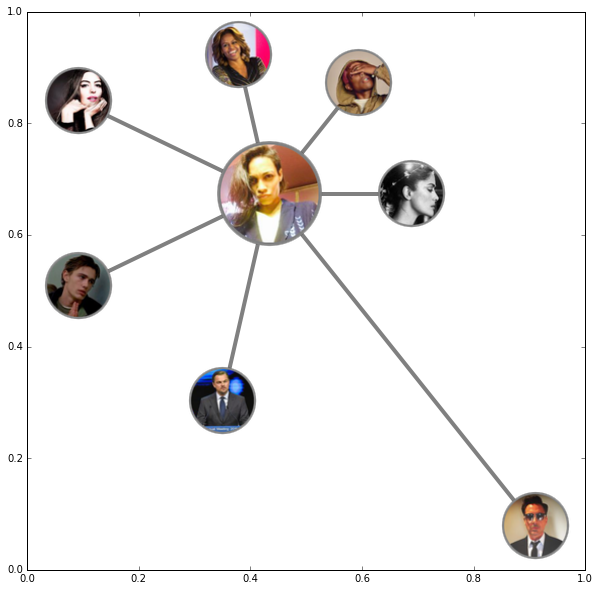

In [47]:
plt.rc('figure', figsize=(10,10))
fig = plt.figure(1)
ax = plt.subplot(111)
plt.xlim(0,1)
plt.ylim(0,1)
#plt.axis('off')
nx.draw_networkx_edges(G, pos = node_pos, width = edge_width, edge_color = 'gray');
trans = ax.transData.transform
trans2 = fig.transFigure.inverted().transform
for n in G:
    xx, yy = ax_trans(node_pos[n])
    xa, ya = fig_trans_inv((xx, yy))
    if n == 0: node_size = prim_width_fig
    else: node_size = sec_width_fig
    a = plt.axes([xa - node_size / 2.0, ya - node_size / 2.0, node_size, node_size])
    a.imshow(G.node[n]['image'])
    a.axis('off') 

Of course, in the final image, we will have white frames and edges, and the axes will be removed.

# Case 2

In case 2, we'll similar as before, although this time, we'll vary r_max, defined in such a way that r varies linearly from r_min (which is now fixed) to some r_max. We'll start with some small r_max, calculate the node positions, and then keep increasing it until we run out of space.

In [63]:
graph_too_big = False
r_max = r_min
while not graph_too_big:
    r_max = r_max + 0.01
    rad_slope = (r_min - r_max) / (max_tags - min_tags)
    rad_intercept = (r_max * max_tags - r_min * min_tags) / (max_tags - min_tags)
    x_pos = []
    y_pos = []
    for n in range(nNodes - 1):
        this_tags = weight_matrix[0,1:][n]
        this_rad = rad_slope * this_tags + rad_intercept
        x_pos = x_pos + [this_rad * cos(n * 2*pi / (nNodes - 1))]
        y_pos = y_pos + [this_rad * sin(n * 2*pi / (nNodes - 1))]
    graph_width = max(x_pos) - min(x_pos) + sec_width_ax
    graph_height = max(y_pos) - min(y_pos) + sec_width_ax
    if (graph_width > 1) | (graph_height > 1): graph_too_big = True
r_max = r_max - 0.01
r_max

0.55401433691756297

As before, go back one step, calculate the relative positions of the nodes, find the position of the central node, and define the position dictionary:

In [64]:
rad_slope = (r_min - r_max) / (max_tags - min_tags)
rad_intercept = (r_max * max_tags - r_min * min_tags) / (max_tags - min_tags)
x_pos = []
y_pos = []
for n in range(nNodes - 1):
    this_tags = weight_matrix[0,1:][n]
    this_rad = rad_slope * this_tags + rad_intercept
    x_pos = x_pos + [this_rad * cos(n * 2*pi / (nNodes - 1))]
    y_pos = y_pos + [this_rad * sin(n * 2*pi / (nNodes - 1))]
graph_width = max(x_pos) - min(x_pos) + sec_width_ax
graph_height = max(y_pos) - min(y_pos) + sec_width_ax

In [65]:
xC = abs(min(x_pos)) + sec_width_ax / 2 + (1 - graph_width) / 2
yC = abs(min(y_pos)) + sec_width_ax / 2 + (1 - graph_height) / 2

In [66]:
node_pos = {0: array([xC, yC])}
for n in range(nNodes - 1):
    node_pos[n + 1] = array([xC + x_pos[n], yC + y_pos[n]])

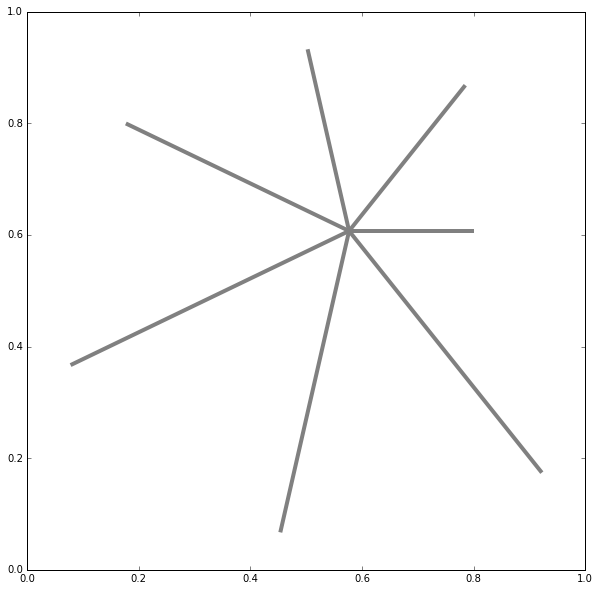

In [67]:
plt.rc('figure', figsize=(fig_width, fig_width))
fig = plt.figure(1)
ax = plt.subplot(111)
plt.xlim(0,1)
plt.ylim(0,1)
nx.draw_networkx_edges(G, pos = node_pos, width = edge_width, edge_color = 'gray');

In [68]:
fig_trans = fig.transFigure.transform
fig_trans_inv = fig.transFigure.inverted().transform
[fig_trans((0,0)), fig_trans((1,1)), fig_trans_inv((720, 720))]

[array([ 0.,  0.]), array([ 800.,  800.]), array([ 0.9,  0.9])]

In [69]:
prim_width_fig = (fig_trans_inv((200 + ppi_conv * prim_width, 200 + ppi_conv * prim_width)) 
                 - fig_trans_inv((200, 200)))[0]
sec_width_fig = (fig_trans_inv((200 + ppi_conv * sec_width, 200 + ppi_conv * sec_width)) 
                - fig_trans_inv((200, 200)))[0]
[prim_width_fig,sec_width_fig]

[0.15277777777777779, 0.09722222222222221]

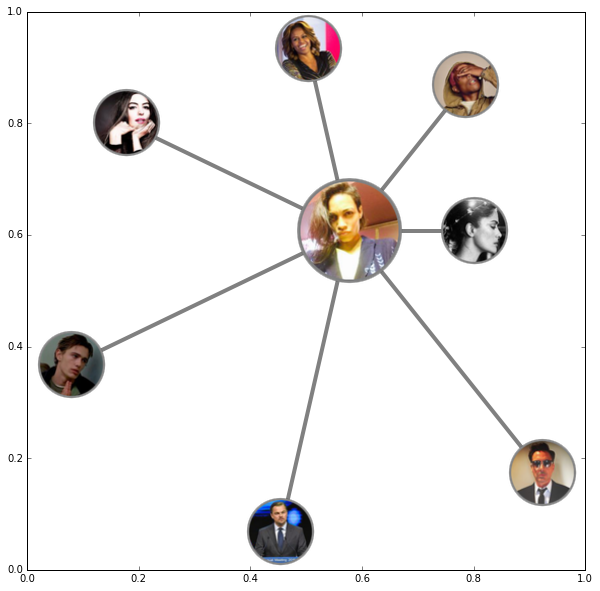

In [70]:
plt.rc('figure', figsize=(10,10))
fig = plt.figure(1)
ax = plt.subplot(111)
plt.xlim(0,1)
plt.ylim(0,1)
#plt.axis('off')
nx.draw_networkx_edges(G, pos = node_pos, width = edge_width, edge_color = 'gray');
trans = ax.transData.transform
trans2 = fig.transFigure.inverted().transform
for n in G:
    xx, yy = ax_trans(node_pos[n])
    xa, ya = fig_trans_inv((xx, yy))
    if n == 0: node_size = prim_width_fig
    else: node_size = sec_width_fig
    a = plt.axes([xa - node_size / 2.0, ya - node_size / 2.0, node_size, node_size])
    a.imshow(G.node[n]['image'])
    a.axis('off') 

In [48]:
fig.savefig('demo2.png', transparent = True, dpi = 72, bbox_inches = 'tight', pad_inches = 0)

# Put it all in functions

Here we will put the code before in functions, so this can be copied into a module.

In [80]:
# Import all the necessary libraries
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from PIL import Image, ImageOps, ImageDraw
import urllib2 as urllib
import io

In [71]:
def circularize(url, width = 100):
    # Load image
    image_file = urllib.urlopen(url)
    image_data = io.BytesIO(image_file.read())
    im = Image.open(image_data)
    # Make it circular (no frame)
    large_size = (im.size[0] * 5, im.size[1] * 5)
    mask = Image.new('L', large_size, 0)
    draw_mask = ImageDraw.Draw(mask) 
    draw_mask.ellipse((0, 0) + large_size, fill = 255)
    mask = mask.resize(im.size, Image.ANTIALIAS)
    im.putalpha(mask)
    # Add a square frame with an offset
    frame_width = 5
    frame_offset = 5
    frame_color = 'white'
    new_size = (im.size[0] + 2*frame_width + 2*frame_offset, im.size[1] + 2*frame_width + 2*frame_offset)
    im_framed = Image.new('RGB', new_size, 'white')
    im_framed.paste(im, (frame_width + frame_offset, frame_width + frame_offset), im)
    # Make the frame circular
    new_large_size = (new_size[0] * 5, new_size[1] * 5)
    new_mask = Image.new('L', new_large_size, 0)
    new_draw_mask = ImageDraw.Draw(new_mask) 
    ellipse_coords = ((frame_offset + im.size[0] + 2*frame_width)*5, (frame_offset + im.size[0] + 2*frame_width)*5)
    new_draw_mask.ellipse((frame_offset * 5, frame_offset * 5) + ellipse_coords, fill = 255)
    new_mask = new_mask.resize(new_size, Image.ANTIALIAS)
    im_framed.putalpha(new_mask)
    # Final resize
    resized_im = im_framed.resize((width, width), Image.ANTIALIAS)
    return resized_im

In [72]:
def scale_node_sizes(fig_width, prim_width, sec_width, r_min_px):
    # Generate an empty plot
    plt.rc('figure', figsize=(fig_width, fig_width))
    fig = plt.figure(1)
    ax = plt.subplot(111)
    plt.xlim(0,1)
    plt.ylim(0,1)
    # Axis <-> display coordinate system transformations
    ax_trans = ax.transData.transform
    ax_trans_inv = ax.transData.inverted().transform
    ppi_conv = 80. / 72.
    prim_width_ax = (ax_trans_inv((200 + ppi_conv * prim_width, 200 + ppi_conv * prim_width))- ax_trans_inv((200, 200)))[0]
    sec_width_ax = (ax_trans_inv((200 + ppi_conv * sec_width, 200 + ppi_conv * sec_width))- ax_trans_inv((200, 200)))[0]
    # Figure <-> display coordinate system transformations
    fig_trans = fig.transFigure.transform
    fig_trans_inv = fig.transFigure.inverted().transform
    prim_width_fig = (fig_trans_inv((200 + ppi_conv * prim_width, 200 + ppi_conv * prim_width))- fig_trans_inv((200, 200)))[0]
    sec_width_fig = (fig_trans_inv((200 + ppi_conv * sec_width, 200 + ppi_conv * sec_width))- fig_trans_inv((200, 200)))[0]
    # Find r_min
    r_min = (ax_trans_inv((200 + ppi_conv * r_min_px, 200 + ppi_conv * r_min_px)) - ax_trans_inv((200, 200)))[0]
    # Close and return
    plt.close()
    return (prim_width_ax, sec_width_ax, prim_width_fig, sec_width_fig, r_min)

In [73]:
def generate_relative_graph(nNodes, r_func, sec_width_ax):
    x_pos = []
    y_pos = []
    for n in range(nNodes - 1):
        x_pos = x_pos + [r_func[n] * cos(n * 2*pi / (nNodes - 1))]
        y_pos = y_pos + [r_func[n] * sin(n * 2*pi / (nNodes - 1))]
    graph_width = max(x_pos) - min(x_pos) + sec_width_ax
    graph_height = max(y_pos) - min(y_pos) + sec_width_ax
    return (x_pos, y_pos, graph_width, graph_height)

In [74]:
def case1_positions(r_min, max_tags, weight_matrix, nNodes, sec_width_ax):
    # Loop until the r_min becomes too big
    graph_too_big = False
    new_r_min = r_min
    while not graph_too_big:
        new_r_min = new_r_min + 0.01
        new_r_trial = (new_r_min * max_tags) / weight_matrix[0,1:]
        (x_pos, y_pos, graph_width, graph_height) = generate_relative_graph(nNodes, new_r_trial, sec_width_ax)
        if (graph_width > 1) | (graph_height > 1): graph_too_big = True
    # Go back one step and recreate all the relative positions
    new_r_min = new_r_min - 0.01
    new_r_trial = (new_r_min * max_tags) / weight_matrix[0,1:]
    (x_pos, y_pos, graph_width, graph_height) = generate_relative_graph(nNodes, new_r_trial, sec_width_ax)
    # Location of the central node
    xC = abs(min(x_pos)) + sec_width_ax / 2 + (1 - graph_width) / 2
    yC = abs(min(y_pos)) + sec_width_ax / 2 + (1 - graph_height) / 2
    # Generate the final position dictionary
    node_pos = {0: array([xC, yC])}
    for n in range(nNodes - 1):
        node_pos[n + 1] = array([xC + x_pos[n], yC + y_pos[n]])
    return node_pos

In [75]:
def case2_positions(r_min, max_tags, min_tags, weight_matrix, nNodes, sec_width_ax):
    # Loop until the r_max becomes too big
    graph_too_big = False
    r_max = r_min
    while not graph_too_big:
        r_max = r_max + 0.01
        rad_slope = (r_min - r_max) / (max_tags - min_tags)
        rad_intercept = (r_max * max_tags - r_min * min_tags) / (max_tags - min_tags)
        this_tags = weight_matrix[0,1:]
        r_trial = rad_slope * this_tags + rad_intercept
        (x_pos, y_pos, graph_width, graph_height) = generate_relative_graph(nNodes, r_trial, sec_width_ax)
        if (graph_width > 1) | (graph_height > 1): graph_too_big = True
    # Go back one step and recreate all the relative positions
    r_max = r_max - 0.01
    rad_slope = (r_min - r_max) / (max_tags - min_tags)
    rad_intercept = (r_max * max_tags - r_min * min_tags) / (max_tags - min_tags)
    this_tags = weight_matrix[0,1:]
    r_trial = rad_slope * this_tags + rad_intercept
    (x_pos, y_pos, graph_width, graph_height) = generate_relative_graph(nNodes, r_trial, sec_width_ax)
    # Location of the central node    
    xC = abs(min(x_pos)) + sec_width_ax / 2 + (1 - graph_width) / 2
    yC = abs(min(y_pos)) + sec_width_ax / 2 + (1 - graph_height) / 2
    # Generate the final position dictionary    
    node_pos = {0: array([xC, yC])}
    for n in range(nNodes - 1):
        node_pos[n + 1] = array([xC + x_pos[n], yC + y_pos[n]])
    return node_pos

In [76]:
def draw_graph(fig_width, G, node_pos, edge_width, prim_width_fig, sec_width_fig):
    # Same plot as before, this time draw edges
    plt.rc('figure', figsize=(fig_width, fig_width))
    fig = plt.figure(1)
    ax = plt.subplot(111)
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.axis('off')
    nx.draw_networkx_edges(G, pos = node_pos, width = edge_width, edge_color = 'white');
    # Convert node axis coordinates to fig coordinates and put the node images there
    ax_trans = ax.transData.transform
    fig_trans_inv = fig.transFigure.inverted().transform
    for n in G:
        xx, yy = ax_trans(node_pos[n])
        xa, ya = fig_trans_inv((xx, yy))
        if n == 0: node_size = prim_width_fig
        else: node_size = sec_width_fig
        a = plt.axes([xa - node_size / 2.0, ya - node_size / 2.0, node_size, node_size])
        a.imshow(G.node[n]['image'])
        a.axis('off') 
    # Save and close
    fig.savefig('network_viz.png', transparent = True, dpi = 72, bbox_inches = 'tight', pad_inches = 0)
    plt.close()
    return None

In [77]:
def network_viz(tag_list, prof_urls, prim_width = 110, sec_width = 70, fig_width = 10, edge_width = 4):
    # Load the pics and circularize them
    node_pics = []
    cnt = 1
    for url in prof_urls:
        if cnt == 1: my_width = prim_width
        else: my_width = sec_width
        node_pics = node_pics + [circularize(url, width = my_width)]
        cnt = cnt + 1
    # Sort the tags and pics
    zip_tag_pics = [(tag_list[0], node_pics[0])] + sorted(zip(tag_list[1:], node_pics[1:]), reverse = True)
    tag_list = [tag for tag, pics in zip_tag_pics]
    node_pics = [pics for tag, pics in zip_tag_pics]
    # Define the weight matrix
    weight_matrix = array([0] * nNodes * nNodes).reshape((nNodes, nNodes))
    weight_matrix[0] = tag_list
    # Build the graph 
    G = nx.from_numpy_matrix(np.matrix(weight_matrix, dtype = [('weight', int)]))
    cnt = 0
    for n in G:
        G.node[n]['image'] = node_pics[cnt]
        cnt = cnt + 1
    # Find the scaled node sizes and r_min
    r_min_px = (prim_width / 2) + (sec_width / 2) + sec_width / 2
    (prim_width_ax, sec_width_ax, prim_width_fig, sec_width_fig, r_min) = scale_node_sizes(fig_width, prim_width, sec_width, r_min_px)
    # Decide which case we have
    min_tags = min(weight_matrix[0,1:])
    max_tags = max(weight_matrix[0,1:])
    r_trial = (r_min * max_tags) / weight_matrix[0,1:]
    (x_pos, y_pos, graph_width, graph_height) = generate_relative_graph(nNodes, r_trial, sec_width_ax)
    if (graph_width <= 1) & (graph_height <= 1): 
        node_pos = case1_positions(r_min, max_tags, weight_matrix, nNodes, sec_width_ax)
    else: 
        node_pos = case2_positions(r_min, max_tags, min_tags, weight_matrix, nNodes, sec_width_ax)
    draw_graph(fig_width, G, node_pos, edge_width, prim_width_fig, sec_width_fig)
    return None

In [78]:
prof_urls = ["https://dl.dropboxusercontent.com/u/51646672/profile_pics_test/prof" 
             + str(i) + ".jpg" for i in range(1,9)]
#tag_list = [0, 3, 3, 3, 2, 2, 2, 1] # Case 1
#tag_list = [0, 4, 3, 3, 2, 1, 1, 1] # Case 2
tag_list = [0, 1, 45, 65, 25, 15, 5, 5]

In [58]:
network_viz(tag_list,prof_urls)